# Visualización Explicable con LIME en InceptionV3
Profesor: Dr. Ing. Rodrigo Salas, Universidad de Valparaíso

[rodrigo.salas@uv.cl](mailto:rodrigo.salas@uv.cl)

Cursillo de Deep Learning aplicado a Imágenes

**Simposio Internacional de Estadística 2025**

**Pasto, Colombia**


En esta práctica usaremos el modelo InceptionV3 preentrenado en ImageNet para clasificar imágenes. Luego aplicaremos la técnica LIME (Local Interpretable Model-agnostic Explanations) para entender qué regiones de la imagen fueron más relevantes para la predicción.

**Recomendación**: crear una copia del notebook para ejecutar el código.

## Librerías a utilizar

In [5]:
#pip install lime

In [6]:
# Librerías generales
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image

# TensorFlow y modelo InceptionV3
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.models import Model

## Preprocesamiento y visualización de las imágenes

Subir previamente las imágenes a archivos de colab

In [7]:
# Rutas de las imágenes
image_paths = [
    "perro.jpg",
    "gato.jpg",
    "tigre.jpg"
]

In [8]:
# Cargar imagenes y preprocesar
img1 = image.load_img(image_paths[0], target_size=(299, 299))      # Redimensionamiento
img1_array = image.img_to_array(img1)                              # Convierte a un arreglo Numpy
img1_array_exp = np.expand_dims(img1_array, axis=0)                # Agrega una dimensión para el lote (batch)

img2 = image.load_img(image_paths[1], target_size=(299, 299))
img2_array = image.img_to_array(img2)
img2_array_exp = np.expand_dims(img2_array, axis=0)

img3 = image.load_img(image_paths[2], target_size=(299, 299))
img3_array = image.img_to_array(img3)
img3_array_exp = np.expand_dims(img3_array, axis=0)

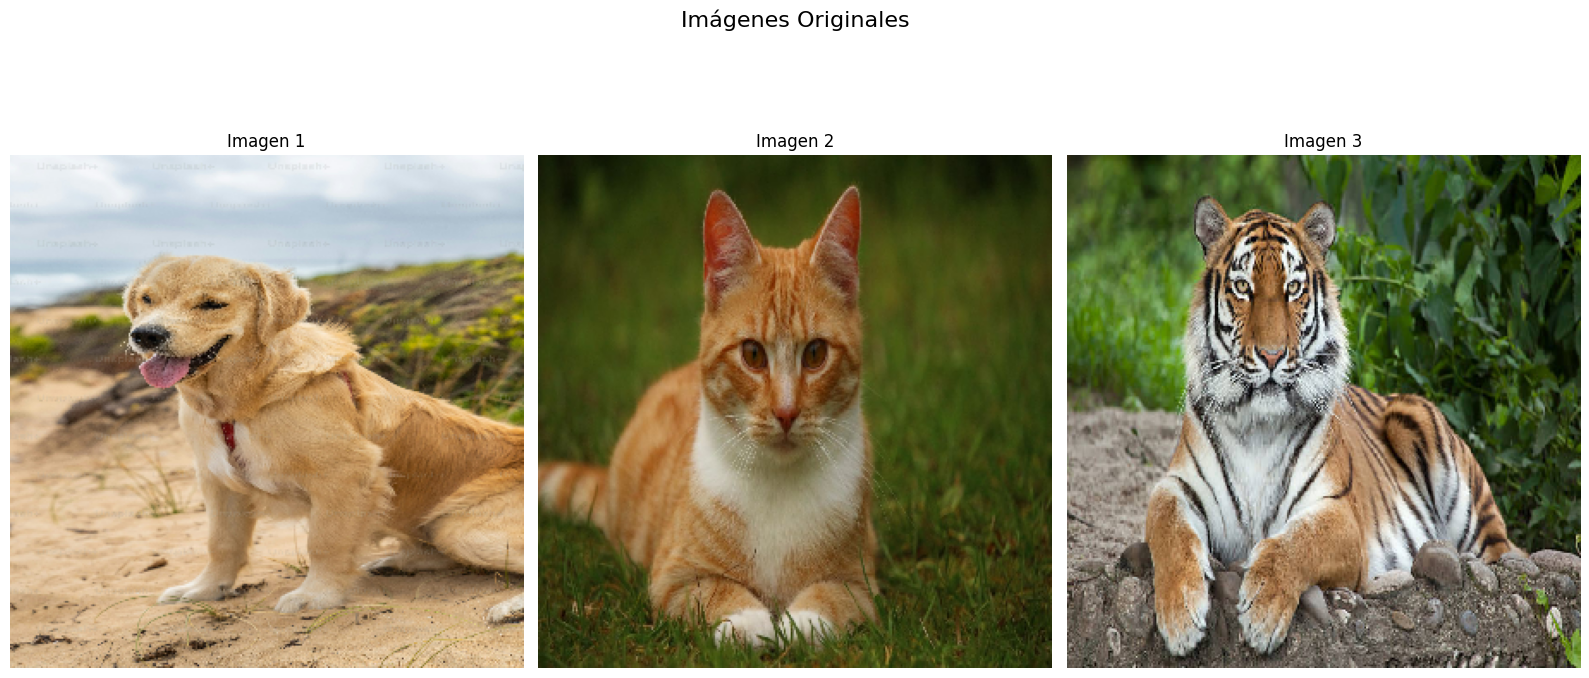

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
fig.suptitle("Imágenes Originales", fontsize=16)

axs[0].imshow(img1)
axs[0].set_title("Imagen 1")
axs[0].axis('off')

axs[1].imshow(img2)
axs[1].set_title("Imagen 2")
axs[1].axis('off')

axs[2].imshow(img3)
axs[2].set_title("Imagen 3")
axs[2].axis('off')

plt.tight_layout()
plt.show()

## Carga del modelo preentrenado InceptionV3

In [10]:
# Modelo InceptionV3 con pesos de ImageNet
base_model = InceptionV3(weights='imagenet')

# Definición del modelo para que devuleva las predicciones
model = Model(inputs=base_model.input, outputs=base_model.output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Función de predicción

In [12]:
# Recibe la lista de imágenes y devuelve la predicción del modelo
def predict_fn(images):
    images = preprocess_input(images) #Aplica normalización
    return model.predict(images)

## Explicador LIME

In [11]:
# Crea un objeto de tipo LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

## Obtención de las predicciones

In [13]:
# Imagen 1
preds1 = model.predict(preprocess_input(img1_array_exp))
decoded1 = decode_predictions(preds1, top=1)[0][0] # Decodifica la etiqueta
label1 = f"Predicción: {decoded1[1].replace('_', ' ')} ({decoded1[2]*100:.1f}%)"

# Imagen 2
preds2 = model.predict(preprocess_input(img2_array_exp))
decoded2 = decode_predictions(preds2, top=1)[0][0]
label2 = f"Predicción: {decoded2[1].replace('_', ' ')} ({decoded2[2]*100:.1f}%)"

# Imagen 3
preds3 = model.predict(preprocess_input(img3_array_exp))
decoded3 = decode_predictions(preds3, top=1)[0][0]
label3 = f"Predicción: {decoded3[1].replace('_', ' ')} ({decoded3[2]*100:.1f}%)"

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


### Uso de LIME

Lo que hace es:
1. Perturbar la imagen original generando 1000 versiones modificadas (con superpíxeles ocultos).
2. Evaluar cada versión con el modelo (a través de predict_fn).
3. Entrenar un modelo lineal local con esos resultados.
4. Determinar qué regiones (superpíxeles) fueron más importantes para la predicción final.

In [14]:
# Aplica Lime a la imagen 1
exp1 = explainer.explain_instance(
    img1_array.astype('double'),  # imagen como un arreglo tipo float64
    classifier_fn=predict_fn,     # retorna las predicciones del modelo
    top_labels=1,                 # genera explicación para la clase más probable
    hide_color=0,
    num_samples=1000             # Número de perturbaciones aleatorias que se generarán para entrenar el modelo local
)

temp1, mask1 = exp1.get_image_and_mask(
    exp1.top_labels[0],      # etiqueta a visualizar
    positive_only=True,      # True, se mostrarán solo las regiones que contribuyen positivamente a esa clase
    num_features=5,          # Número de superpíxeles a destacar
    hide_rest=False          # True, oculta todo lo que no sea relevante
)

# Combina la imagen original con la máscara para visualizar los límites de los superpíxeles más importantes
# mark_boundaries dibuja los contornos de los superpíxeles seleccionados sobre la imagen
lime1 = mark_boundaries(np.array(img1) / 255.0, mask1)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [15]:
# Se repite exactamente el mismo procedimiento para la segunda imagen
exp2 = explainer.explain_instance(img2_array.astype('double'), classifier_fn=predict_fn, top_labels=1, hide_color=0, num_samples=1000)
temp2, mask2 = exp2.get_image_and_mask(exp2.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
lime2 = mark_boundaries(np.array(img2) / 255.0, mask2)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [16]:
# Se repite exactamente el mismo procedimiento para la tercera imagen
exp3 = explainer.explain_instance(img3_array.astype('double'), classifier_fn=predict_fn, top_labels=1, hide_color=0, num_samples=1000)
temp3, mask3 = exp3.get_image_and_mask(exp3.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
lime3 = mark_boundaries(np.array(img3) / 255.0, mask3)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

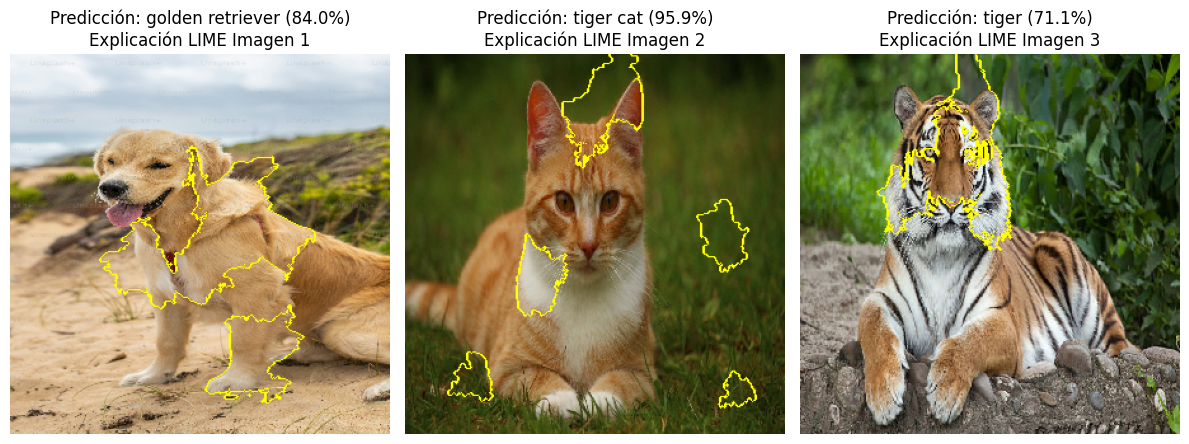

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(lime1)
ax[0].set_title(f"{label1}\nExplicación LIME Imagen 1")
ax[0].axis('off')

ax[1].imshow(lime2)
ax[1].set_title(f"{label2}\nExplicación LIME Imagen 2")
ax[1].axis('off')

ax[2].imshow(lime3)
ax[2].set_title(f"{label3}\nExplicación LIME Imagen 3")
ax[2].axis('off')

plt.tight_layout()
plt.show()